In [ ]:
!pip install mxnet-mkl==1.6.0 numpy==1.23.1

In [ ]:
!pip install mxnet
!pip install gluonnlp==0.10.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch

In [ ]:
# KoBERT
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

# Import Libraries

In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import tqdm

In [ ]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
device = torch.device("cuda:0")

# Load Data

In [ ]:
root = '/content/drive/MyDrive/iNotePal/감정대화데이터셋'
df = pd.read_csv(os.path.join(root, 'conv-7_dataset.csv'))

In [ ]:
df = pd.read_excel('short.xlsx', usecols=['Sentence', 'Emotion'])
df

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
...,...,...
38589,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라..,혐오
38590,재미가 없으니 망하지,혐오
38591,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,혐오
38592,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,혐오


In [ ]:
import pickle

with open('preprocessed.txt', 'rb') as f:
    data = pickle.load(f)
data

In [10]:
len(data)

38161

In [12]:
df_part = df[:38161]
df_part['processed'] = data
df_part

<ipython-input-12-7af394ff9df7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part['processed'] = data


,Sentence,Emotion,processed
0,언니 동생으로 부르는게 맞는 일인가요..??,공포,언니 동생으로 부르는 게 맞는 일인가요??
1,그냥 내 느낌일뿐겠지?,공포,그냥 느낌일 뿐이겠지?
2,아직너무초기라서 그런거죠?,공포,아직 너무 초기라서 거죠?
3,유치원버스 사고 낫다던데,공포,유치원 버스 사고 낫다던데
4,근데 원래이런거맞나요,공포,근데 원래 거 맞나요
...,...,...,...
38156,피해망상 장난아니구요,혐오,피해 망상 장난 아니고요
38157,솔까 니들이 더하지.,혐오,솔 까니 더하지
38158,다 국회계신 돼지분들 아가리에 쳐들어간거지,혐오,다 국회 계신 돼지 분들 아가리에 쳐들어간 거지
38159,서비스 하지말지 사고 날 확률이 많아,혐오,서비스하지 말지 사고 날 확률이 많아


### LabelEncoder

In [14]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df_part['label'] = LE.fit_transform(df_part['Emotion'])

labels = LE.classes_
print(len(labels), labels)

7 ['공포' '놀람' '분노' '슬픔' '중립' '행복' '혐오']


<ipython-input-14-5de3574be55b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part['label'] = LE.fit_transform(df_part['Emotion'])


In [49]:
df_part['Emotion'].value_counts()

Emotion
행복    6037
놀람    5898
분노    5665
공포    5468
슬픔    5267
혐오    4996
중립    4830
Name: count, dtype: int64

### Re-arrange Data

In [15]:
data_list = []
for q, label in zip(df_part['processed'], df_part['label']):
  data = []
  data.append(q)
  data.append(label)
  data_list.append(data)
data_list[:5]

[['언니 동생으로 부르는 게 맞는 일인가요??', 0],
 ['그냥 느낌일 뿐이겠지?', 0],
 ['아직 너무 초기라서 거죠?', 0],
 ['유치원 버스 사고 낫다던데', 0],
 ['근데 원래 거 맞나요', 0]]

### Train / Test Split

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_list, test_size=0.25, random_state=0, shuffle=True)

print(len(train), len(test))

28620 9541


# KoBERTTokenizer

In [17]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


### token length

In [18]:
class BERTDataset(Dataset):
    def __init__(self, dataset, q_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[q_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [20]:
tok = tokenizer.tokenize
max_len = 300

trainset = BERTDataset(train, 0, 1, tok, vocab, max_len, True, False) # 294
testset = BERTDataset(test, 0, 1, tok, vocab, max_len, True, False) # 215

token_len_train = [d[1] for d in trainset]
token_len_test = [d[1] for d in testset]

In [21]:
print(min(token_len_train), max(token_len_train))
print(min(token_len_test), max(token_len_test))

2 176
2 295


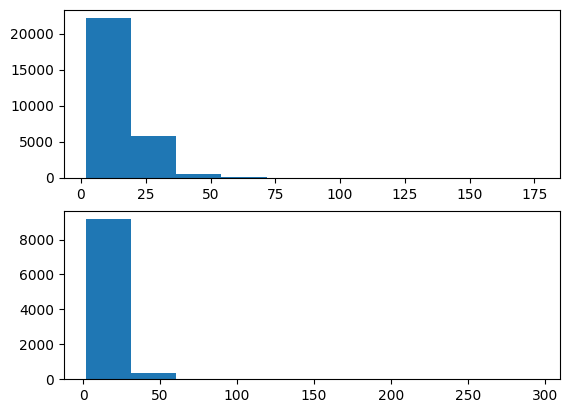

In [22]:
fig, ax = plt.subplots(2, 1)

ax[0].hist(token_len_train)
ax[1].hist(token_len_test)

plt.show()

### Tokenization

In [47]:
tok = tokenizer.tokenize
max_len = 64
batch_size = 16

trainset = BERTDataset(train, 0, 1, tok, vocab, max_len, True, False) # 294
testset = BERTDataset(test, 0, 1, tok, vocab, max_len, True, False) # 215

In [48]:
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

# Model Training

### KoBERT Model

In [27]:
# get KoBERT model
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [50]:
# set params
num_classes = len(labels)
num_epochs = 20
warmup_ratio = 0.1
max_grad_norm = 1
log_interval = 200
learning_rate = 0.01

In [51]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [52]:
model = BERTClassifier(bertmodel, num_classes=num_classes, dr_rate=0.4).to(device)

In [53]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [54]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [55]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

##### Training

In [57]:
best_test_acc = 0.0
best_model = None

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
    tot_train_acc = train_acc / (batch_id+1)
    print("epoch {} train acc {}".format(e+1, tot_train_acc))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    tot_acc = test_acc / (batch_id+1)
    print("epoch {} test acc {}".format(e+1, tot_acc))
    if best_test_acc < tot_acc:
      best_test_acc = tot_acc
      best_model = deepcopy(model.state_dict())

  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 1 train acc 0.14516955468604434


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 1 test acc 0.13810720268006701


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 2 train acc 0.14693963107881497


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 2 test acc 0.16226968174204356


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 3 train acc 0.14691634059996272


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 3 test acc 0.12732412060301507


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 4 train acc 0.14869806223215948


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 4 test acc 0.12732412060301507


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 5 train acc 0.14470374510899944


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 5 test acc 0.14719430485762144


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 6 train acc 0.14851173840134152


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 6 test acc 0.14719430485762144


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 7 train acc 0.14770821688093907


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 7 test acc 0.14719430485762144


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 8 train acc 0.14861654555617662


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 8 test acc 0.14719430485762144


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 9 train acc 0.15186556735606485


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 9 test acc 0.14719430485762144


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 10 train acc 0.15190050307434322


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 10 test acc 0.14719430485762144


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 11 train acc 0.15173746972237748


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 11 test acc 0.1530778894472362


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 12 train acc 0.15425284143841997


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 12 test acc 0.1530778894472362


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 13 train acc 0.15535913918390162


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 13 test acc 0.16226968174204356


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 14 train acc 0.15619759642258244


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 14 test acc 0.16226968174204356


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 15 train acc 0.1564887274082355


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 15 test acc 0.1530778894472362


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 16 train acc 0.15206353642630893


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 16 test acc 0.14719430485762144


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 17 train acc 0.1480925097820011


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 17 test acc 0.14719430485762144


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 18 train acc 0.15466042481833425


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 18 test acc 0.14719430485762144


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 19 train acc 0.15144633873672442


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 19 test acc 0.14719430485762144


  0%|          | 0/1789 [00:00<?, ?it/s]

epoch 20 train acc 0.15120178870877585


  0%|          | 0/597 [00:00<?, ?it/s]

epoch 20 test acc 0.14719430485762144


In [ ]:
torch.save(model.state_dict(), 'KoBERT_best.pt')

##### Evaluation

In [ ]:
def predict(predict_sentence, model, labels):

    data = [predict_sentence]
    label = [0]

    dataset = BERTDataset(data, label, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            print(f'Prediction result : {labels[np.argmax(logits)]}')